In [1]:
from scipy import stats
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Bayesian Bandit

### Sizhang Lyu

We will first generate the true probabilities of winning of the 3 games. Here, we will generate 3 ransom numbers from $[0,1]$ and scale them by their weights so that they sum to 1. Note that these true values are not observed and are hidden from the algorithm. They are only used to simulate the "observed data."

In [9]:
# generate the true probabilities
random.seed(0)
random_numbers = [random.random() for _ in range(3)]
random_numbers = [num / sum(random_numbers) for num in random_numbers]
real_probs = {'Red': random_numbers[0], 'Blue': random_numbers[1], 'Other': random_numbers[2]}
options = ['Red', 'Blue', 'Other']
real_probs

{'Red': 0.4174214662344023,
 'Blue': 0.3746781749462781,
 'Other': 0.20790035881931965}

Then we can set up the first prior distributions of $\theta_A, \theta_B, \theta_C$. Since we do not observe any data yet, we will assume they all follow a uniform distribution, i.e., a $Beta(1,1)$ distribution.

In [10]:
# set up non-informative priors for the 3 games, i.e., Beta(1,1) distribution.
prior_R = {'alpha': 1, 'beta': 1}
prior_B = {'alpha': 1, 'beta': 1}
prior_O = {'alpha': 1, 'beta': 1}

The idea here is to perform sequential updating, and the strategy is as follows. We will draw 1 random sample from our priors and pick the option with the largest value, and this will be our prior belief of which option will win. Then we will simulate the real result based on the true probabilities we simulated earlier. Finally we will update the posterior based on the "observed data" and our prior, since, as we derived, the posterior of the beta-binomial model is proportional to $\theta^{x+\alpha-1}(1-\theta)^{n-x+\beta-1}$. We will use the posterior of the previous iteration as our new prior and repeat the procedure for a desired amount of iterations, which, in this case, 100.

In [11]:
# run the simulation to update the priors
np.random.seed(0)
data = [("_", prior_R, prior_B, prior_O)]
for i in range(100):
  R, B, O = stats.beta.rvs(prior_R['alpha'], prior_R['beta']), stats.beta.rvs(prior_B['alpha'], prior_B['beta']), stats.beta.rvs(prior_O['alpha'], prior_O['beta'])
  max_option = options[np.argmax([R, B, O])]
  simluated_game = 1 if real_probs[max_option] > stats.uniform.rvs(0,1) else 0
  if max_option == 'Red':
    prior_R = {'alpha': prior_R['alpha'] + simluated_game, 'beta': prior_R['beta'] + 1 - simluated_game}
  if max_option == 'Blue':
    prior_B = {'alpha': prior_B['alpha'] + simluated_game, 'beta': prior_B['beta'] + 1 - simluated_game}
  if max_option == 'Other':
    prior_O = {'alpha': prior_O['alpha'] + simluated_game, 'beta': prior_O['beta'] + 1 - simluated_game}
  data.append((max_option, prior_R, prior_B, prior_O))

Here we can print the results of the last 10 iterations to see if they converge. As we can see, 9 out of 10 draws are red, which coincides with the true probabilities we generated, where red has the largest probability of winnning (0.4174214662344023).

In [12]:
# print the last 10 draws
result_lst = []
for i in range(len(data)):
  result_lst.append(data[i][0])
print(result_lst[-10:])

['Red', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red']


We can also create visualization of draws to check for convergence. The following code was inspired by https://www.kaggle.com/code/mlwhiz/bayesian-bandits/notebook?scriptVersionId=17478592

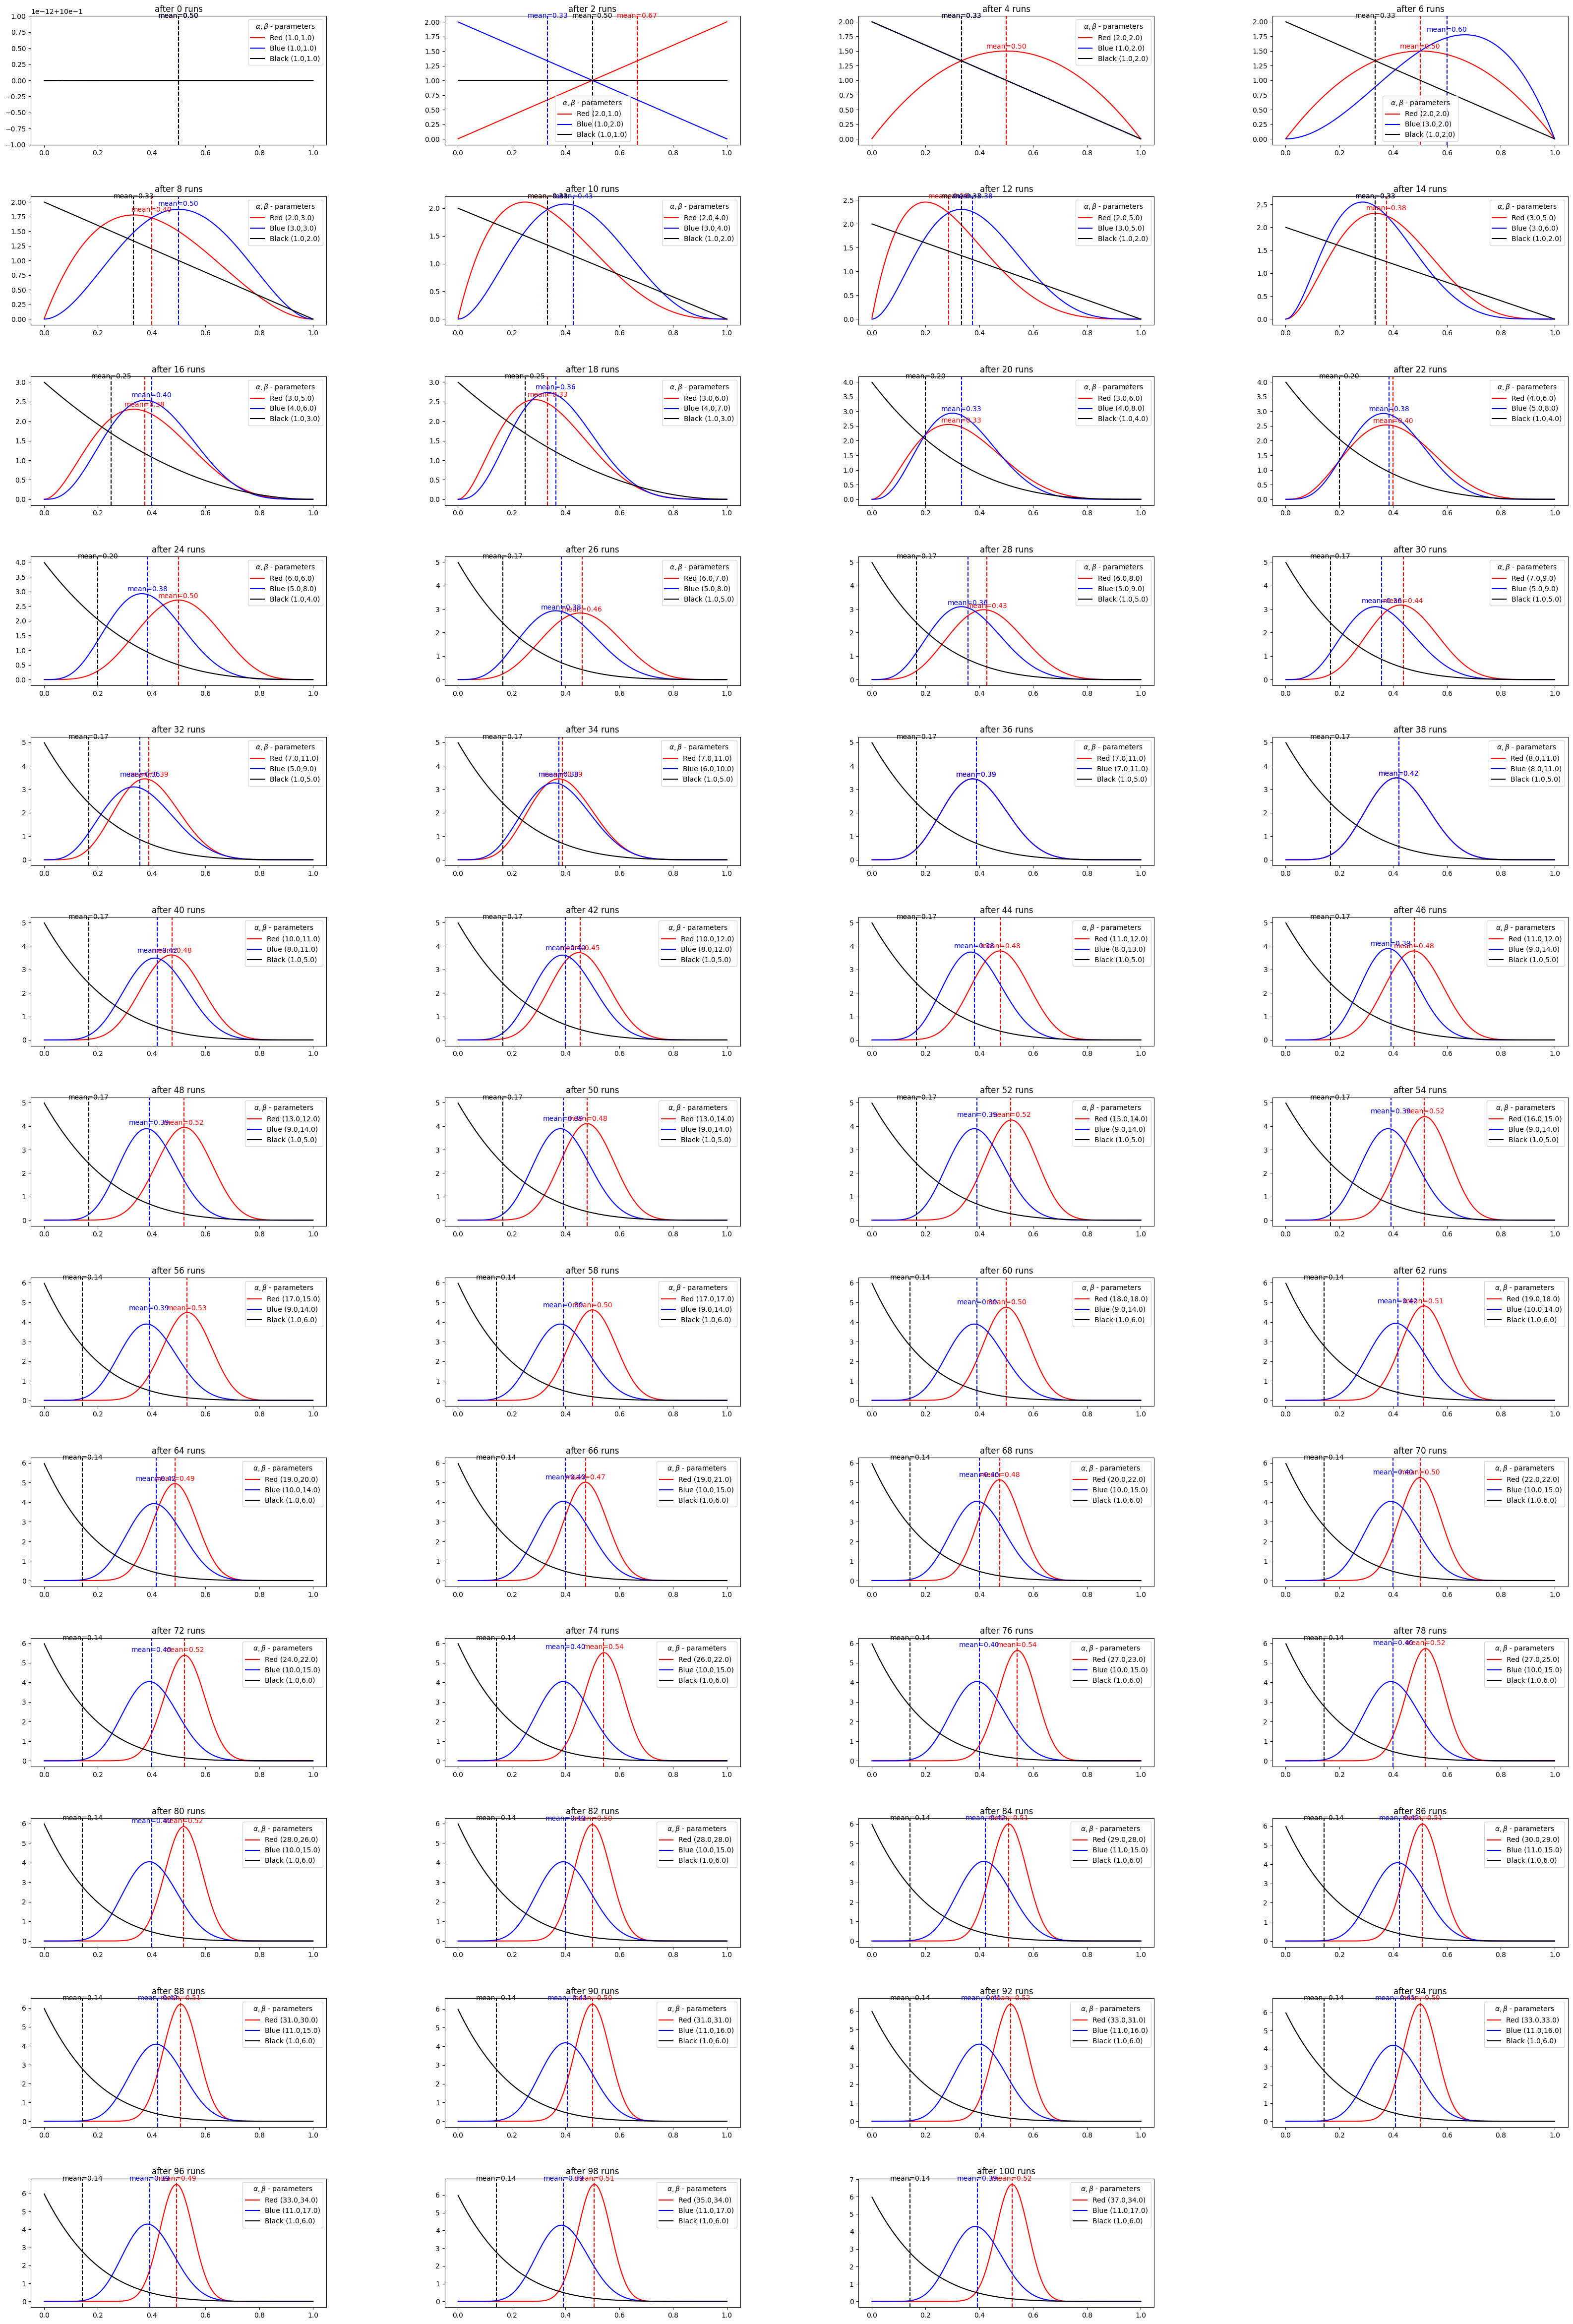

In [22]:
fig = plt.figure(figsize=(40, 60))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
count = 1
for i in range(0, 101, 2):
    ax = fig.add_subplot(13, 4, count)
    params = [data[i][1], data[i][2], data[i][3]]
    x = np.linspace(0.001, 1, 150)
    for j in range(len(params)):
        alpha, beta = params[j]['alpha'], params[j]['beta']
        mean = alpha / (alpha + beta)
        color = 'Black' if j == 2 else options[j]
        y = stats.beta.pdf(x, alpha, beta)
        sns.lineplot(x=x, y=y, label="%s (%.1f,%.1f)" % (color, alpha, beta), color=color, ax=ax)
        ax.axvline(x=mean, color=color, linestyle='--')
        ax.text(mean, ax.get_ylim()[1], f'mean={mean:.2f}', color=color, ha='center', va='center')
    ax.legend(title=r"$\alpha, \beta$ - parameters")
    ax.set_title("after " + str(i) + " runs")
    count += 1
plt.show()

As we can see, the shapes of the posteriors start to stabilize after approximately 70 rounds, and the relative rank of the probabilities are the same as the actual values.